# C8Steerable CNN


In [1]:
try:
    done
except:
    import os

    os.chdir("../../../")
    from utils.download import download
    from utils.extract import extract

    args = {"model": "Model-2"}
    download(args)
    extract("data/Model_II.tgz", "data/")
    extract("data/Model_II_test.tgz", "data/")
    done = True

Downloading...
From (uriginal): https://drive.google.com/uc?id=1HYPkdtVUj9xsoGzFDxT4rhl37KmqDCg4
From (redirected): https://drive.google.com/uc?id=1HYPkdtVUj9xsoGzFDxT4rhl37KmqDCg4&confirm=t&uuid=1dbbf58e-22fe-446d-b325-a9aa707d879a
To: /opt/repo/GSoC-23/data/Model_II.tgz
100%|██████████| 2.84G/2.84G [00:41<00:00, 67.7MB/s]
Downloading...
From (uriginal): https://drive.google.com/uc?id=1PFdpqk7XOAKtg0Cnav4HTzyJiudx9dZv
From (redirected): https://drive.google.com/uc?id=1PFdpqk7XOAKtg0Cnav4HTzyJiudx9dZv&confirm=t&uuid=b2d581e3-8f95-45d8-87bd-f78c60568a2e
To: /opt/repo/GSoC-23/data/Model_II_test.tgz
100%|██████████| 478M/478M [00:09<00:00, 48.6MB/s]


In [2]:
import copy
import warnings

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

from itertools import cycle
from PIL import Image
from sklearn.metrics import (
    auc,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_auc_score,
    roc_curve,
)
from torch import optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms


from tqdm import tqdm

warnings.filterwarnings("ignore")

# Data Preparation


In [3]:
train_transforms = transforms.Compose([
#     transforms.RandomCrop(128),
    transforms.Resize(128),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize(128),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor()
])

In [4]:
def npy_loader(path):
    if 'axion' in path:
        sample = np.load(path, allow_pickle=True)[0]
    else:
        sample = np.load(path, allow_pickle=True)
    sample = 255 * (sample / sample.max())
    sample = Image.fromarray(sample.astype('uint8')).convert("RGB")
    return sample
    

trainset = datasets.DatasetFolder(
    root='data/Model_II',
    loader=npy_loader,
    extensions=['.npy'],
    transform = train_transforms
)

testset = datasets.DatasetFolder(
    root='data/Model_II_test',
    loader=npy_loader,
    extensions=['.npy'],
    transform = test_transforms
)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=64,shuffle=True)
test_loader = torch.utils.data.DataLoader(testset, batch_size=64,shuffle=True)

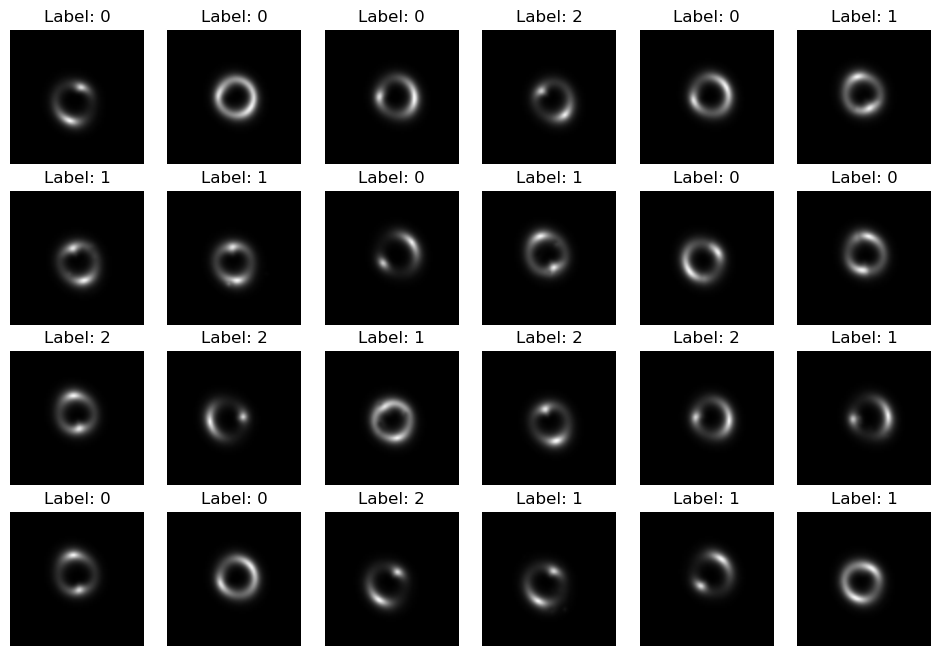

In [5]:
num_images = len(trainset)
num_rows = 4
num_cols = 6

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.1, hspace=0.2)

for i in range(num_rows):
    for j in range(num_cols):
        index = np.random.randint(num_images)
        if index >= num_images:
            break

        image, label = trainset[index]
        image = image.permute(1, 2, 0)  # Convert from (C, H, W) to (H, W, C)

        axes[i][j].imshow(image, cmap='gray')
        axes[i][j].set_title(f"Label: {label}")
        axes[i][j].axis('off')

plt.show()

In [6]:
lr = 0.0001
epochs = 10
gamma = 0.7
batch_size = 64
device = "cuda" if torch.cuda.is_available() else "cpu"

# Model


In [7]:
model = torchvision.models.resnet18(pretrained=True)
model.fc = torch.nn.Linear(512, 3, bias=True)
model = model.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 312MB/s]


# Training


In [8]:
all_train_loss = []
all_test_loss = []
all_train_accuracy = []
all_test_accuracy = []

best_accuracy = 0

for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0
    correct, total = 0, 0
    model.train()
    tr_loss_epoch = []
    test_loss_epoch = []
    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss = criterion(output, label)
        tr_loss_epoch.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        acc = (output.argmax(dim=1) == label).sum()
        correct += acc.item()
        total += len(label)

        epoch_loss += loss / len(train_loader)
    scheduler.step()
    all_train_loss.append(np.asarray(tr_loss_epoch))
    all_train_accuracy.append(correct / total * 100)
    epoch_accuracy = (correct / total) * 100
    correct, total = 0, 0

    torch.cuda.empty_cache()
    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in tqdm(test_loader):
            data = data.to(device)
            label = label.to(device)

            val_output = model(data)
            val_loss = criterion(val_output, label)
            test_loss_epoch.append(val_loss.item())
            acc = (val_output.argmax(dim=1) == label).sum()
            correct += acc.item()
            total += len(label)

            epoch_val_loss += val_loss / len(test_loader)
        all_test_loss.append(np.asarray(test_loss_epoch))
        all_test_accuracy.append(correct / total * 100)
    epoch_val_accuracy = (correct / total) * 100

    if epoch_val_accuracy > best_accuracy:
        best_accuracy = epoch_val_accuracy
        best_model = copy.deepcopy(model)

    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f}% - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}%"
    )
torch.save(best_model.state_dict(), "equi_nn.pth")
all_train_loss_mean = [j.mean() for j in all_train_loss]
all_test_loss_mean = [j.mean() for j in all_test_loss]

100%|██████████| 235/235 [01:15<00:00,  3.10it/s]


Epoch : 1 - loss : 0.2724 - acc: 89.2766% - val_loss : 0.1552 - val_acc: 94.5867%


100%|██████████| 235/235 [01:18<00:00,  3.01it/s]


Epoch : 2 - loss : 0.1138 - acc: 96.1124% - val_loss : 0.0924 - val_acc: 97.1067%


100%|██████████| 235/235 [01:33<00:00,  2.52it/s]


Epoch : 3 - loss : 0.0747 - acc: 97.4872% - val_loss : 0.0613 - val_acc: 97.9600%


100%|██████████| 235/235 [00:50<00:00,  4.65it/s]


Epoch : 4 - loss : 0.0587 - acc: 98.0573% - val_loss : 0.0829 - val_acc: 97.4000%


100%|██████████| 235/235 [01:15<00:00,  3.13it/s]


Epoch : 5 - loss : 0.0476 - acc: 98.4378% - val_loss : 0.0567 - val_acc: 98.1400%


100%|██████████| 235/235 [00:42<00:00,  5.54it/s]


Epoch : 6 - loss : 0.0404 - acc: 98.7127% - val_loss : 0.0495 - val_acc: 98.3667%


100%|██████████| 235/235 [00:19<00:00, 12.05it/s]


Epoch : 7 - loss : 0.0346 - acc: 98.9091% - val_loss : 0.0495 - val_acc: 98.2933%


100%|██████████| 235/235 [00:26<00:00,  9.03it/s]


Epoch : 8 - loss : 0.0322 - acc: 98.9899% - val_loss : 0.0452 - val_acc: 98.5400%


100%|██████████| 235/235 [01:23<00:00,  2.83it/s]


Epoch : 9 - loss : 0.0292 - acc: 99.0651% - val_loss : 0.0310 - val_acc: 99.0667%


100%|██████████| 235/235 [01:06<00:00,  3.55it/s]

Epoch : 10 - loss : 0.0263 - acc: 99.1628% - val_loss : 0.0311 - val_acc: 99.1333%


# Plotting Loss and Accuracy


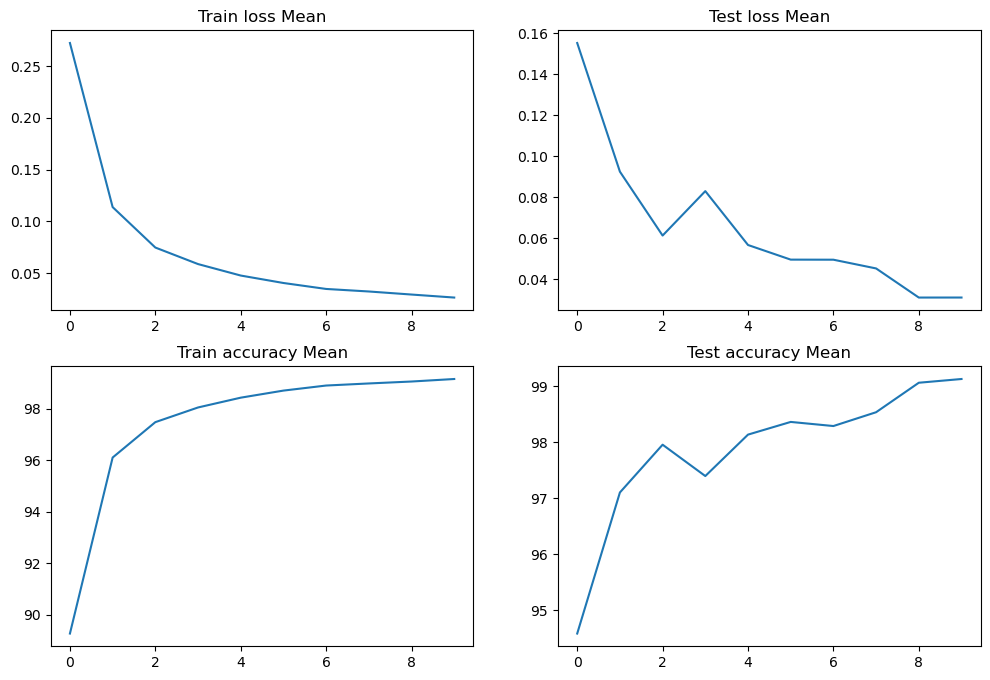

In [9]:
figure = plt.figure(figsize=(12, 8))
cols, rows = 2, 2
figure.add_subplot(rows, cols, 1)
plt.title("Train loss Mean")
plt.plot(all_train_loss_mean)
figure.add_subplot(rows, cols, 2)
plt.title("Test loss Mean")
plt.plot(all_test_loss_mean)
figure.add_subplot(rows, cols, 3)
plt.title("Train accuracy Mean")
plt.plot(all_train_accuracy)
figure.add_subplot(rows, cols, 4)
plt.title("Test accuracy Mean")
plt.plot(all_test_accuracy)

# Loading Best Model


In [10]:
model = torchvision.models.resnet18(pretrained=True)
model.fc = torch.nn.Linear(512, 3, bias=True)
model = model.to(device)
model.load_state_dict(torch.load("equi_nn.pth"), strict=False)

<All keys matched successfully>

# Testing


In [11]:
true_label, pred_label, pred_score, one_hot = [], [], [], []
with torch.no_grad():
    model.eval()
    for i, (x, y) in enumerate(tqdm(test_loader)):
        x = x.to(device)
        y = y.to(device)
        _y = model(x)

        _, pred = torch.max(_y.data, 1)
        true_label += y.tolist()
        pred_label += pred.tolist()
        pred_score += _y.tolist()
        one_hot += np.eye(3)[y.cpu().numpy()].tolist()

100%|██████████| 235/235 [01:00<00:00,  3.86it/s]


# Confusion Matrix


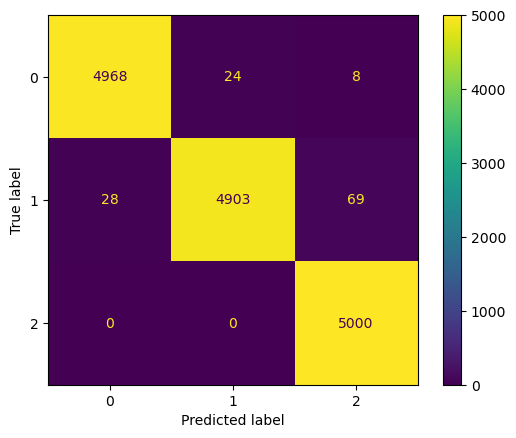

In [12]:
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(true_label, pred_label)).plot()

# AUC Score


In [13]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

In [14]:
roc_auc_score(np.array(true_label),[softmax(i) for i in np.array(pred_score)], multi_class='ovr')

0.9995908733333333

# ROC-CURVE


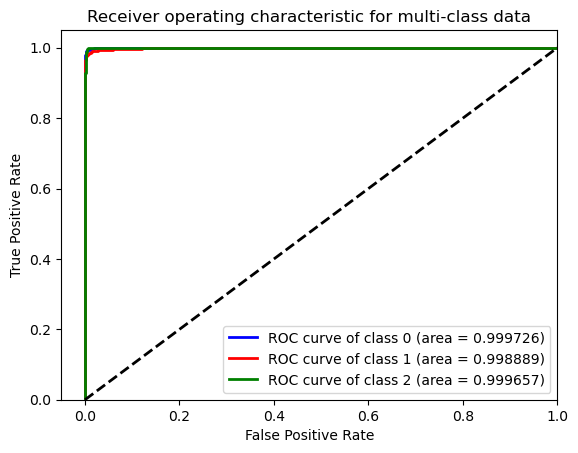

In [15]:
fpr = dict()
tpr = dict()
roc_auc = dict()
lw=2
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(np.array(one_hot)[:, i], np.array(pred_score)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(3), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.6f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()